---

### ModelInterface_Examples.ipynb

---

Testing the functionality of the transient_smash package/modules

In [2]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
import transient_smash
from transient_smash.models.model import Model,SinusoidalModelWithNoise

---

Try using one of the pre-defined models - SinusoidalModelWithNoise()

$$ \mathrm{y = A \sin(2\pi fx + \phi) + b + noise}$$

In [ ]:
x = np.linspace(0,10,1000)
noiseless_params = [1,1,1,1,0,0]# single (A, f, phi, b, noise_mean, noise_std)

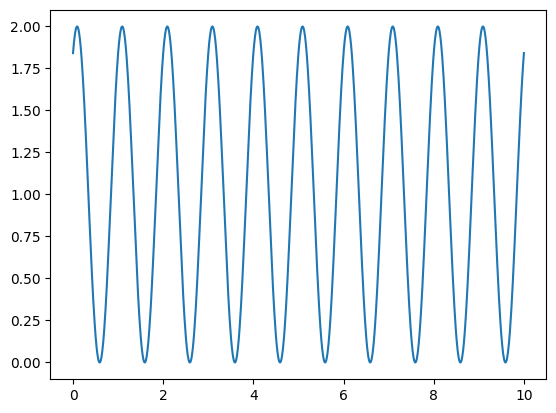

In [10]:
obs = SinusoidalModelWithNoise().evaluate(x,noiseless_params)

plt.figure()
plt.plot(x,obs)
plt.show()

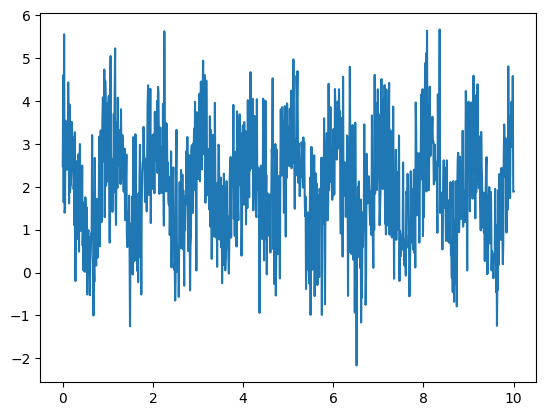

In [ ]:
noisy_params = [1,1,1,1,1,1]
obs = SinusoidalModelWithNoise().evaluate(x,noisy_params)

plt.figure()
plt.plot(x,obs)
plt.show()

---

Try generating a new type of model - Building on the Model() base class

In [ ]:
### Setting up a new type of model using the Model() base class
class GaussianModelWithNoise(Model):
    """A model with a periodic Gaussian signal and Gaussian noise.

       For a non-periodic signal set period -> inf.
    """
    
    def evaluate(self, x: np.ndarray, params: np.ndarray) -> np.ndarray:
        """Evaluate the Gaussian signal model with noise.

        Args:
            x: Input data for the model.
            params: Model parameters (signal_centre, signal_std, period, baseline, noise_mean, noise_std).

        Returns:
            Model output evaluated at the given input data plus noise.
        """
        
        params = np.array(params)  # handle both np/torch uniformly
        if params.ndim == 1:  # single (signal_centre, signal_std, period, baseline, noise_mean, noise_std)
            signal_centre, signal_std, period, baseline, noise_mean, noise_std = params
        elif params.ndim == 2:  # (signal_centre, signal_std, period, baseline, noise_mean, noise_std) pairs
            signal_centre = params[:, 0][:, None]  # shape (N, 1)
            signal_std = params[:, 1][:, None]  # shape (N, 1)
            period = params[:, 2][:, None]  # shape (N, 1)
            baseline = params[:, 3][:, None]  # shape (N, 1)
            noise_mean = params[:, 4][:, None]  # shape (N, 1)
            noise_std = params[:, 5][:, None]  # shape (N, 1)
        else:
            err_str = f"Unexpected params shape: {params.shape}"
            raise Exception(err_str)

        current_loc = signal_centre - 50 * period
        signal = np.zeros(len(x))
        while current_loc<2*max(x):
            signal += norm.pdf(x,loc=current_loc,scale=signal_std)
            current_loc += period
        
        return np.ones(len(x))*baseline + signal +\
        self.noise(x, noise_mean, noise_std)

    def noise(self, x: np.ndarray, noise_mean: np.ndarray, 
              noise_std: np.ndarray) -> np.ndarray:
        """Simulate the noise to apply to the model.

        Args:
            x: Input data for the model.
            noise_mean: Mean of the noise distribution.
            noise_std: Standard deviation of the noise distribution.
        """
        return norm.rvs(loc=noise_mean, scale=noise_std, size=len(x))

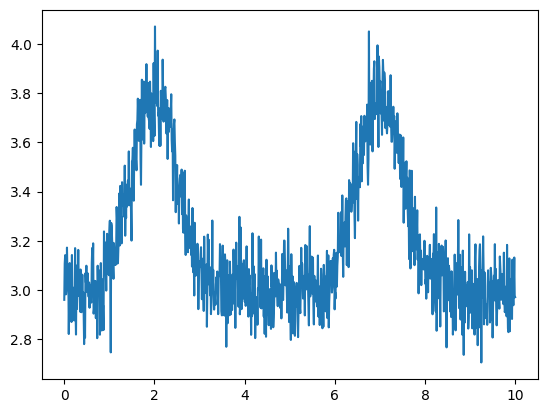

In [ ]:
x = np.linspace(0,10,1000)
params = [2,0.5,5,3,0,0.1] # (signal_centre, signal_std, period, baseline, noise_mean, noise_std)

obs = GaussianModelWithNoise().evaluate(x,params)

plt.figure()
plt.plot(x,obs)
plt.show()